In [1]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [2]:
#Libraries

from __future__ import print_function, division
from builtins import range, input
import tensorflow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D,Dropout,Conv2D,Activation,MaxPooling2D,BatchNormalization,MaxPool2D
from tensorflow.keras.models import Model, load_model,Sequential
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau, TensorBoard
import cv2 
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
from sklearn.metrics import classification_report
#Test Train Split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

In [3]:

#define paths
models_path = r"C:/Users/T-x23/Downloads/Mini_project_Covid19/models/"

covid_path =r"C:\Users\T-x23\Downloads\Mini_project_Covid19\data\Chest_COVID"
noncovid_path =r"C:\Users\T-x23\Downloads\Mini_project_Covid19\data\Chest_NonCOVID"


# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')

In [4]:
#Fetch images and Class Labels 
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

for i in range(len(covid_files)):
    image = cv2.imread(covid_files[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(224,224))
    covid_images.append(image)
    covid_labels.append('Chest_COVID')
for i in range(len(noncovid_files)):
    image = cv2.imread(noncovid_files[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(224,224))
    noncovid_images.append(image)
    noncovid_labels.append('Chest_NonCOVID')


In [5]:
#We must do normalization and form of pizels [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

In [6]:

# split into training and testing
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(covid_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(noncovid_images, noncovid_labels, test_size=0.2)


X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# make labels into categories - either 0 or 1
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

In [3]:
#CNN MODEL

model=Sequential()

model.add(Conv2D(32,kernel_size=(3,3),input_shape=(224,224,3)))
model.add(Activation('relu'))

model.add(Conv2D(32,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))



model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2,activation="softmax"))


model.compile(loss=tensorflow.keras.losses.binary_crossentropy,optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 222, 222, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 220, 220, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 108, 108, 128)     36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 128)       0

In [22]:
model

In [23]:
#genrerator Aug,
train_aug = ImageDataGenerator(rotation_range=20,width_shift_range=0.2, height_shift_range=0.2,horizontal_flip=True)

In [24]:
batch_size=32
epochs =200
early_stop = EarlyStopping( min_delta=0, patience=50, verbose=1, mode='auto')
#EarlyStopping(monitor='val_loss', mode="min",verbose =1) 
checkpointer = ModelCheckpoint( filepath=models_path+'cnn.h5', verbose=1, save_best_only=True, mode = 'auto')
lr_reducer = ReduceLROnPlateau( patience=10, verbose=1)



In [25]:

#Train the model
hist = model.fit(train_aug.flow(X_train, y_train, batch_size=batch_size),validation_data=(X_test, y_test),
                    callbacks=[checkpointer, early_stop,lr_reducer],shuffle=True,
                    validation_steps=len(X_test) / batch_size,steps_per_epoch=len(X_train) / batch_size,epochs=epochs)



Train for 23.5 steps, validate on 188 samples
Epoch 1/200
23/23 [============================>.] - ETA: 0s - loss: 1.5697 - accuracy: 0.5375
Epoch 00001: val_loss improved from inf to 0.68502, saving model to C:/Users/T-x23/Downloads/Mini_project_Covid19/models/cnn.h5
24/23 [==============================] - 12s 495ms/step - loss: 1.5334 - accuracy: 0.5439 - val_loss: 0.6850 - val_accuracy: 0.6755
Epoch 2/200
23/23 [============================>.] - ETA: 0s - loss: 0.6760 - accuracy: 0.5931
Epoch 00002: val_loss improved from 0.68502 to 0.64662, saving model to C:/Users/T-x23/Downloads/Mini_project_Covid19/models/cnn.h5
24/23 [==============================] - 11s 440ms/step - loss: 0.6755 - accuracy: 0.5944 - val_loss: 0.6466 - val_accuracy: 0.6968
Epoch 3/200
23/23 [============================>.] - ETA: 0s - loss: 0.6391 - accuracy: 0.6208
Epoch 00003: val_loss improved from 0.64662 to 0.55443, saving model to C:/Users/T-x23/Downloads/Mini_project_Covid19/models/cnn.h5
24/23 [======

Epoch 27/200
23/23 [============================>.] - ETA: 0s - loss: 0.4956 - accuracy: 0.7611
Epoch 00027: val_loss improved from 0.40898 to 0.39506, saving model to C:/Users/T-x23/Downloads/Mini_project_Covid19/models/cnn.h5
24/23 [==============================] - 10s 421ms/step - loss: 0.4932 - accuracy: 0.7646 - val_loss: 0.3951 - val_accuracy: 0.8191
Epoch 28/200
23/23 [============================>.] - ETA: 0s - loss: 0.5653 - accuracy: 0.7403
Epoch 00028: val_loss did not improve from 0.39506
24/23 [==============================] - 11s 463ms/step - loss: 0.5646 - accuracy: 0.7394 - val_loss: 0.4197 - val_accuracy: 0.8511
Epoch 29/200
23/23 [============================>.] - ETA: 0s - loss: 0.5731 - accuracy: 0.7056
Epoch 00029: val_loss did not improve from 0.39506
24/23 [==============================] - 11s 459ms/step - loss: 0.5705 - accuracy: 0.7088 - val_loss: 0.4573 - val_accuracy: 0.8511
Epoch 30/200
23/23 [============================>.] - ETA: 0s - loss: 0.5557 - acc

Epoch 55/200
23/23 [============================>.] - ETA: 0s - loss: 0.4470 - accuracy: 0.7861
Epoch 00055: val_loss did not improve from 0.36158
24/23 [==============================] - 12s 502ms/step - loss: 0.4473 - accuracy: 0.7819 - val_loss: 0.4140 - val_accuracy: 0.8138
Epoch 56/200
23/23 [============================>.] - ETA: 0s - loss: 0.4367 - accuracy: 0.7958
Epoch 00056: val_loss did not improve from 0.36158
24/23 [==============================] - 11s 475ms/step - loss: 0.4344 - accuracy: 0.7952 - val_loss: 0.4183 - val_accuracy: 0.8032
Epoch 57/200
23/23 [============================>.] - ETA: 0s - loss: 0.4470 - accuracy: 0.7948
Epoch 00057: val_loss did not improve from 0.36158
24/23 [==============================] - 11s 456ms/step - loss: 0.4447 - accuracy: 0.7965 - val_loss: 0.4009 - val_accuracy: 0.8617
Epoch 58/200
23/23 [============================>.] - ETA: 0s - loss: 0.4352 - accuracy: 0.7875
Epoch 00058: val_loss did not improve from 0.36158
24/23 [=========

Epoch 84/200
23/23 [============================>.] - ETA: 0s - loss: 0.4018 - accuracy: 0.8236
Epoch 00084: val_loss did not improve from 0.33101
24/23 [==============================] - 11s 457ms/step - loss: 0.4005 - accuracy: 0.8231 - val_loss: 0.3583 - val_accuracy: 0.8457
Epoch 85/200
23/23 [============================>.] - ETA: 0s - loss: 0.3913 - accuracy: 0.8181
Epoch 00085: val_loss did not improve from 0.33101
24/23 [==============================] - 12s 499ms/step - loss: 0.3932 - accuracy: 0.8191 - val_loss: 0.3583 - val_accuracy: 0.8457
Epoch 86/200
23/23 [============================>.] - ETA: 0s - loss: 0.3971 - accuracy: 0.8208
Epoch 00086: val_loss did not improve from 0.33101
24/23 [==============================] - 11s 463ms/step - loss: 0.3927 - accuracy: 0.8205 - val_loss: 0.3584 - val_accuracy: 0.8457
Epoch 87/200
23/23 [============================>.] - ETA: 0s - loss: 0.4053 - accuracy: 0.8208
Epoch 00087: val_loss did not improve from 0.33101
24/23 [=========

In [28]:
model.save(models_path+'cnn.h5')
model.save_weights(models_path+'cnn.hdf5')
model = load_model(models_path+'cnn.h5')

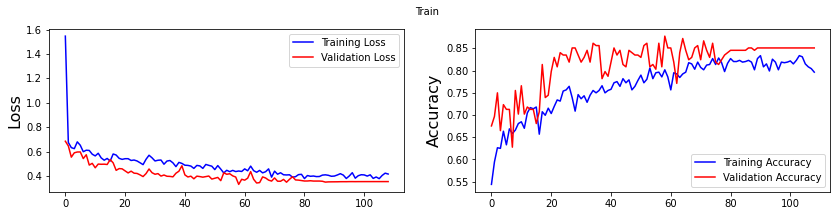

In [26]:
plt.figure(figsize=(14,3))
plt.subplot(1, 2, 1)
plt.suptitle('Train', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [27]:
scores = model.evaluate(np.array(X_test), np.array(y_test), batch_size=32)
scores

188/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.3540126934964606, 0.85106385]

In [15]:
#making prediction
y_pred = model.predict(X_test, batch_size=batch_size)

In [16]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

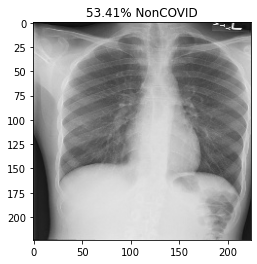

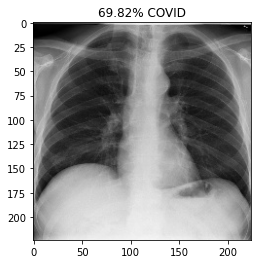

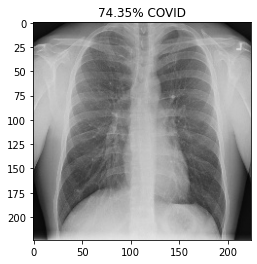

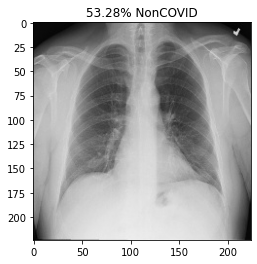

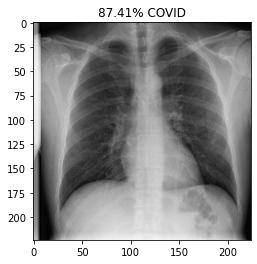

In [17]:
#Lets see some of predictions
prediction=y_pred[0:5]
for index, probability in enumerate(prediction):
    if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
    else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
    plt.imshow(X_test[index])
    plt.show()

Text(0.5, 1.0, 'CNN Model ')

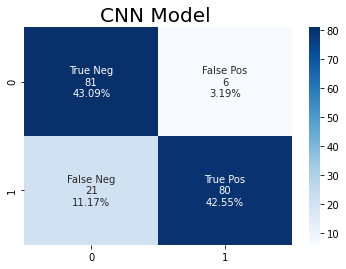

In [21]:
cf_matrix = confusion_matrix(y_test_bin,y_pred_bin)
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='Blues')
plt.title("CNN Model ", fontsize =20)

In [22]:
print ('\nClasification report:\n', classification_report(y_test_bin, y_pred_bin))


Clasification report:
               precision    recall  f1-score   support

           0       0.79      0.93      0.86        87
           1       0.93      0.79      0.86       101

    accuracy                           0.86       188
   macro avg       0.86      0.86      0.86       188
weighted avg       0.87      0.86      0.86       188

